## Files and Image Generation

In this notebook I show how to split the full ghosts dataset into smaller datasets and how to automatically generate jpg images containing them.

**Import basic packages**

In [1]:
import numpy as np 
import scipy as sp
import pandas as pd

# ============
import imageio



# Matplotlib, seaborn and plot pretty 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    plt.rc('text', usetex=False)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

**Import the data**

Train data

In [2]:
X_train_temp = np.load("train_set/x_ghstcln400-cnn5_ins4.npy")/255.0 #Images
y_train_temp = np.load("train_set/y_ghstcln400-cnn5_fix9z0_ins4.npy")#Labels
z_train_temp = np.load("train_set/z_ghstcln400-cnn5_ins4.npy")#contains expnum, year, and filter for each image in "x"

Test data

In [3]:
X_test_temp = np.load("test_set/x_ghstcln400-tstdat.npy")/255.0 #Images
y_test_temp = np.load("test_set/y_ghstcln400-tstdat.npy")#Labels
z_test_temp = np.load("test_set/z_ghstcln400-tstdat.npy")#contains expnum, year, and filter for each image in "x"

In [4]:
print(np.shape(X_train_temp))
print(np.shape(X_test_temp))

(5079, 400, 400)
(1792, 400, 400)


I will focus on the *training data*.

First things first, let's buckle those belts.
I mean, let's get only those that refer to ghosts, which means $y=1$

In [5]:
X_train_ghosts = X_train_temp[(y_train_temp==1.0)]
z_train_ghosts = z_train_temp[(y_train_temp==1.0)]

In [6]:
print(z_train_temp[0])

('D00360471', 'xx', 'g')


In [7]:
print(np.shape(X_train_ghosts))

(2499, 400, 400)


In [8]:
print((z_train_ghosts['expnum']))

['D00232695' 'D00229997' 'D00472570' ... 'D00262607' 'D00241043'
 'D00513795']


In [9]:
# Get exposure numbers (expnum)
expnum_train = z_train_ghosts['expnum']

print(expnum_train[0])

D00232695


### Demo using the first 20 examples

Create .jpg images of the first 20 ghost examples.

Select, convert and save as a three-channel image.

In [10]:
n = 20 # Number of ghost photos to consider 

for i in range(n):
    # Get local matrix and exposure number
    x_loc = X_train_ghosts[i]
    expnum_loc = expnum_train[i]
    
    leng = np.shape(x_loc)[0] #Size of image (400pixels)
    # For three channels
    X_ghost_3ch = np.zeros((leng,leng,3))

    #Populate 
    X_ghost_3ch[:,:,0] = x_loc
    X_ghost_3ch[:,:,1] = x_loc
    X_ghost_3ch[:,:,2] = x_loc
    
    
    # Save the image
    imageio.imwrite("Ghost_img_{0}.jpg".format(expnum_loc),(X_ghost_3ch*255.).astype(np.uint8))
    
    

**Keep only doubly classifies as ghost-containing** 

Now, I will keep only those images classified as having ghosts by *both* the ray-tracing algorithm **and** the convolutional neural network.

In [11]:
# Ray tracing-based dataframe
Ray_tracing_df = pd.read_csv("Labels_ray.csv",encoding='utf8')
# CNN-based dataframe
CNN_df = pd.read_csv("Labels_CNN.csv")

In [12]:
Ray_tracing_df.head()

,expnum,label
0,360471,0
1,369762,0
2,232695,1
3,601480,0
4,229997,1


In [13]:
# Get the exposure numbers in each case
Expnum_ray = Ray_tracing_df['  expnum'].values
Expnum_CNN = CNN_df['  expnum'].values
# Now get the labels
Label_ray = Ray_tracing_df['label'].values
Label_CNN = CNN_df['label_pred'].values
#And the scores for the CNN
Scores_CNN = CNN_df['score']

In [14]:
Expnum_Ghost = Expnum_ray[(Label_ray==1)&(Scores_CNN>0.95)]
print(len(Expnum_Ghost))

2199


In [15]:
X_ghosts_conf = X_train_temp[(Label_ray==1)&(Scores_CNN>0.95)]
z_ghosts_conf = z_train_temp[(Label_ray==1)&(Scores_CNN>0.95)]
# Expnum
expnum_ghosts_conf = z_ghosts_conf['expnum']

In [16]:
j = -120
print(expnum_ghosts_conf[j])
print(Expnum_Ghost[j])

D00363955
363955


Let's inspect a few, visually

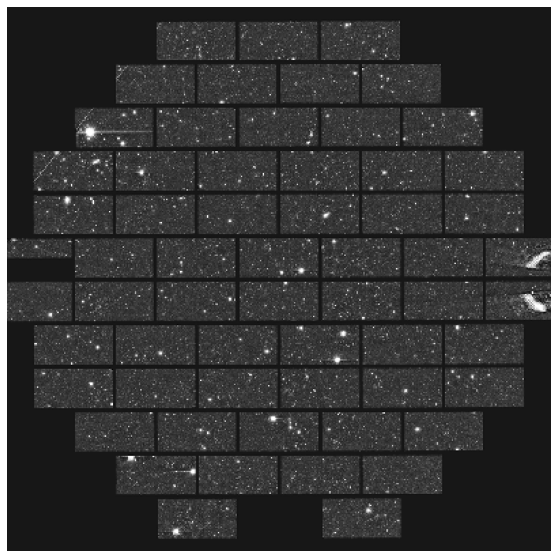

In [17]:
j=1504
plot_pretty() 
plt.figure(figsize=(10, 10))

plt.imshow(X_ghosts_conf[j],cmap='gray')
plt.axis('off')

plt.show()

**Save the first 100 images in a folder with my name.**

In [23]:
n = 100
for i in range(n):
    j = i + 500
    # Get local matrix and exposure number
    x_loc = X_ghosts_conf[j]
    expnum_loc = expnum_ghosts_conf[j]
    
    leng = np.shape(x_loc)[0] #Size of image (400pixels)
    # For three channels
    X_ghost_3ch = np.zeros((leng,leng,3))

    #Populate 
    X_ghost_3ch[:,:,0] = x_loc
    X_ghost_3ch[:,:,1] = x_loc
    X_ghost_3ch[:,:,2] = x_loc
    
    #print(i+1,expnum_loc)
    
    # Save the image
    #imageio.imwrite("./Ariel_4/Ghost_img_{0}.jpg".format(expnum_loc),(X_ghost_3ch*255.).astype(np.uint8))
    

**Randomly select 50 images that will be annotated by everyone**

Name this file the "common core"

In [24]:
print(np.shape(X_ghosts_conf))
n_ghosts = len(expnum_ghosts_conf)

(2199, 400, 400)


In [25]:
import random
rands = random.sample(range(1,2000),50)
print(rands)

[93, 1933, 1275, 1013, 1920, 535, 1528, 1152, 497, 289, 121, 241, 1307, 12, 1829, 1393, 811, 594, 82, 1853, 564, 726, 424, 1862, 541, 1798, 1110, 702, 1803, 441, 1561, 1895, 530, 1846, 1121, 1021, 640, 472, 867, 532, 561, 1748, 1359, 221, 487, 1386, 1884, 1216, 246, 65]


In [27]:
for i in range(50):
    j = rands[i]
    # Get local matrix and exposure number
    x_loc = X_ghosts_conf[j]
    expnum_loc = expnum_ghosts_conf[j]
    
    leng = np.shape(x_loc)[0] #Size of image (400pixels)
    # For three channels
    X_ghost_3ch = np.zeros((leng,leng,3))

    #Populate 
    X_ghost_3ch[:,:,0] = x_loc
    X_ghost_3ch[:,:,1] = x_loc
    X_ghost_3ch[:,:,2] = x_loc
    
    # Save the image
    #imageio.imwrite("./Common_core/Ghost_img_{0}.jpg".format(expnum_loc),(X_ghost_3ch*255.).astype(np.uint8))
    

#### Get images that the NN classified as having ghosts and the ray-tracing algorithm classified them as not having ghosts

In [28]:
X_ghosts_esc = X_train_temp[(Label_ray==0)&(Scores_CNN>0.80)]
z_ghosts_esc = z_train_temp[(Label_ray==0)&(Scores_CNN>0.80)]
# Expnum
expnum_ghosts_esc = z_ghosts_esc['expnum']

In [29]:
print(len(expnum_ghosts_esc))

35


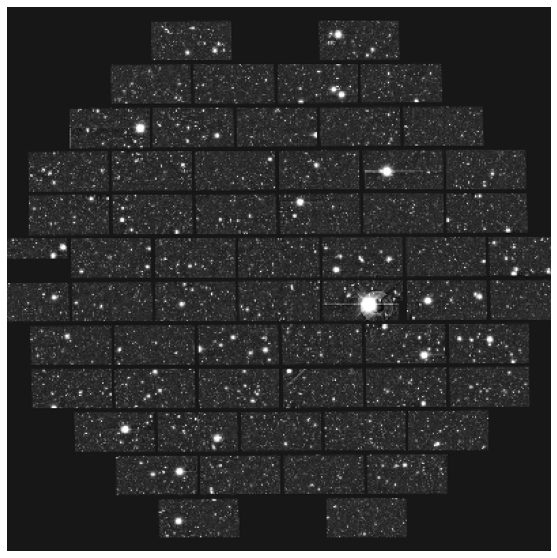

In [30]:
j=6
plot_pretty() 
plt.figure(figsize=(10, 10))

plt.imshow(X_ghosts_esc[j],cmap='gray')
plt.axis('off')

plt.show()

In [31]:
n = 35
for i in range(n):
    j = i
    # Get local matrix and exposure number
    x_loc = X_ghosts_esc[j]
    expnum_loc = expnum_ghosts_esc[j]
    
    leng = np.shape(x_loc)[0] #Size of image (400pixels)
    # For three channels
    X_ghost_3ch = np.zeros((leng,leng,3))

    #Populate 
    X_ghost_3ch[:,:,0] = x_loc
    X_ghost_3ch[:,:,1] = x_loc
    X_ghost_3ch[:,:,2] = x_loc
    
    # Save the image
    imageio.imwrite("./Ghosts_undetected/Ghost_img_{0}.jpg".format(expnum_loc),(X_ghost_3ch*255.).astype(np.uint8))
    

In [32]:
print(Expnum_ray[(Label_ray==0)&(Scores_CNN>0.8)])

[230538 253727 155483 175567 717359 543344 404823 268429 482125 723649
 581288 229255 158170 260584 408156 409087 589315 571485 515738 810302
 180826 481561 482127 575006 391337 383224 270028 352832 274735 252304
 233467 569657 514855 177767 157868]


In [33]:
print(expnum_ghosts_esc)

['D00230538' 'D00253727' 'D00155483' 'D00175567' 'D00717359' 'D00543344'
 'D00404823' 'D00268429' 'D00482125' 'D00723649' 'D00581288' 'D00229255'
 'D00158170' 'D00260584' 'D00408156' 'D00409087' 'D00589315' 'D00571485'
 'D00515738' 'D00810302' 'D00180826' 'D00481561' 'D00482127' 'D00575006'
 'D00391337' 'D00383224' 'D00270028' 'D00352832' 'D00274735' 'D00252304'
 'D00233467' 'D00569657' 'D00514855' 'D00177767' 'D00157868']


### CCD mapping

In [34]:
from run import fov_geometry
ccds = np.asarray(fov_geometry(release='y1a1',size=[400,400]))

print(np.shape(ccds))

print(ccds[25])
name = ccds[:,0]
x_min = ccds[:,1]
y_min = ccds[:,2]
x_max = ccds[:,3]
y_max = ccds[:,4]

x_min_pr = x_min + (x_min-200)*38.5*0.0025
x_max_pr = x_max + (x_max-200)*38.5*0.0025

(62, 5)
[ 26 282 168 337 200]


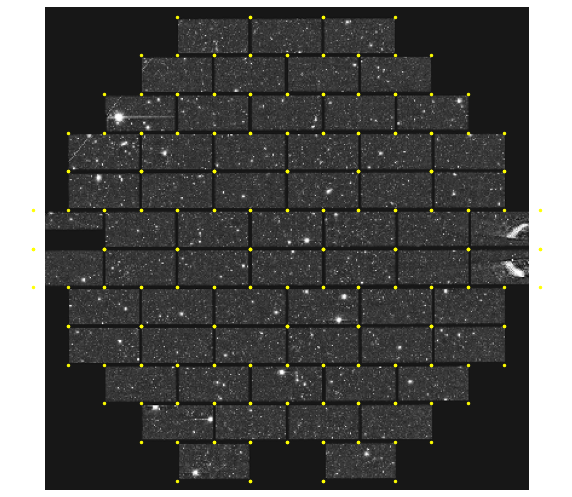

In [35]:
j=1504
plot_pretty() 
plt.figure(figsize=(10, 10))

plt.imshow(X_ghosts_conf[j],cmap='gray')
plt.scatter(x_min_pr,y_min,color='yellow',s=5.8)
plt.scatter(x_min_pr,y_max,color='yellow',s=5.8)
plt.scatter(x_max_pr,y_max,color='yellow',s=5.8)
plt.scatter(x_max_pr,y_min,color='yellow',s=5.8)
plt.axis('off')

plt.savefig('CCDs.png')
plt.show()

### Finding and masking a CCD

In the following cells, I'm trying to build a code that:

For a given pixel (in the range $0-400$ in each one of the $x,y$ directions):

- Finds the CCD it belongs to.
- Creates a mask over that CCD and displays a mask within the figure.

In [31]:
x_loc = 220
y_loc = 154

mask = (x_max_pr>x_loc)&(x_min_pr<x_loc)&(y_max>y_loc)&(y_min<y_loc)

CCD_is = name[mask]-1 # This finds the CCD
CCD_is = 0

In [32]:
import numpy.ma as ma
X_mask = np.zeros([400,400])

X_mask[int(y_min[CCD_is]):int(y_max[CCD_is])+1,int(x_min_pr[CCD_is]):int(x_max_pr[CCD_is])+1] =1 

#for i in range(400):
#    for j in range(400):
#        if ((i>x_min_pr[CCD_is])&(i<x_max_pr[CCD_is])&(j>y_min[CCD_is])&(j<y_max[CCD_is])):
#            X_mask[j,i] = 1
        
mask_CCD = ma.masked_where(X_mask<1, X_mask)
X_mask_CCD = ma.masked_array(X_mask,mask_CCD)

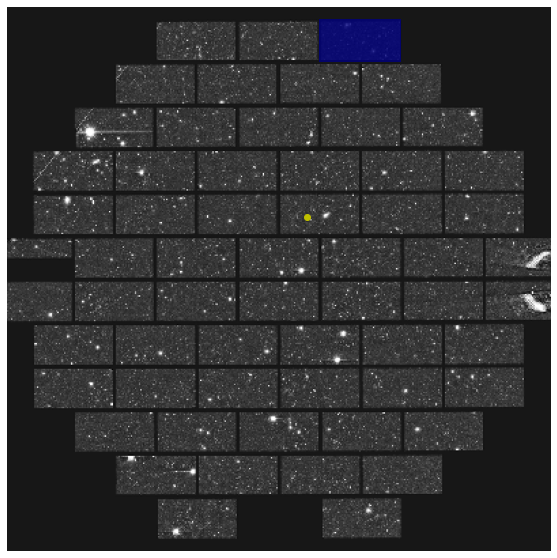

In [33]:
plot_pretty() 
plt.figure(figsize=(10, 10))

plt.imshow(X_ghosts_conf[j],cmap='gray')
plt.scatter(x_loc,y_loc,color='y')
plt.imshow(mask_CCD,cmap='jet',alpha=0.8)
plt.axis('off')

#plt.savefig('CCDs.png')
plt.show()

### Ray Tracing

First import the files containing the exposure numbers (`expnum`) and the numbers representing the bad CCDs for each `expnum`, according to the ray tracing algorithm.

In [34]:
expnum_1, ccd_1, ccdnum_1 = np.loadtxt("ghost-scatter-y1.txt",  unpack=3, usecols=[1,2,4])
expnum_2, ccd_2, ccdnum_2 = np.loadtxt("ghost-scatter-y2.txt",  unpack=3, usecols=[1,2,4])
expnum_3, ccd_3, ccdnum_3 = np.loadtxt("ghost-scatter-y3.txt",  unpack=3, usecols=[1,2,4])
expnum_4, ccd_4, ccdnum_4 = np.loadtxt("ghost-scatter-y4.txt",  unpack=3, usecols=[1,2,4])
expnum_5, ccd_5, ccdnum_5 = np.loadtxt("ghost-scatter-y5.txt",  unpack=3, usecols=[1,2,4])
expnum_6, ccd_6, ccdnum_6 = np.loadtxt("ghost-scatter-y6.txt",  unpack=3, usecols=[1,2,4])

In [35]:
expnum = np.concatenate((expnum_1,expnum_2,expnum_3,expnum_4,expnum_5,expnum_6)).astype(int)
ccd = np.concatenate((ccd_1,ccd_2,ccd_3,ccd_4,ccd_5,ccd_6)).astype(int)
ccdnum = np.concatenate((ccdnum_1,ccdnum_2,ccdnum_3,ccdnum_4,ccdnum_5,ccdnum_6)).astype(int)

In [36]:
# Create dataframe

In [37]:
from collections import OrderedDict

Exp_CCD_df = pd.DataFrame( OrderedDict(( 
    ('expnum', pd.Series(expnum)),
    ('ccd', pd.Series(ccd)),
    ('ccdnum', pd.Series(ccdnum)))))
# =============================================
# =============================================
Exp_CCD_df.head()

,expnum,ccd,ccdnum
0,226651,11,38
1,226651,48,31
2,229257,14,35
3,229257,15,34
4,229257,21,41


In [38]:
print(ccdnum[expnum==229257])

[35 34 41 40 27 23 22 17 16]


**Write function that for given image/exposure number finds and masks the bad CCDs.**

In [142]:
img_number = 27

img = X_ghosts_conf[img_number]
expnum_loc = Expnum_Ghost[img_number]

print(expnum_loc)

159127


Get affected CCDs

In [143]:
aff_CCDs = ccdnum[expnum==expnum_loc]-1
print(aff_CCDs)

[]


In [144]:
X_mask = np.zeros([400,400])

for i in range(len(aff_CCDs)):
    CCD_loc = aff_CCDs[i]
    X_mask[int(y_min[CCD_loc]):int(y_max[CCD_loc])+1,int(x_min_pr[CCD_loc]):int(x_max_pr[CCD_loc])+1] =1 

In [145]:
mask_CCD = ma.masked_where(X_mask<1, X_mask)

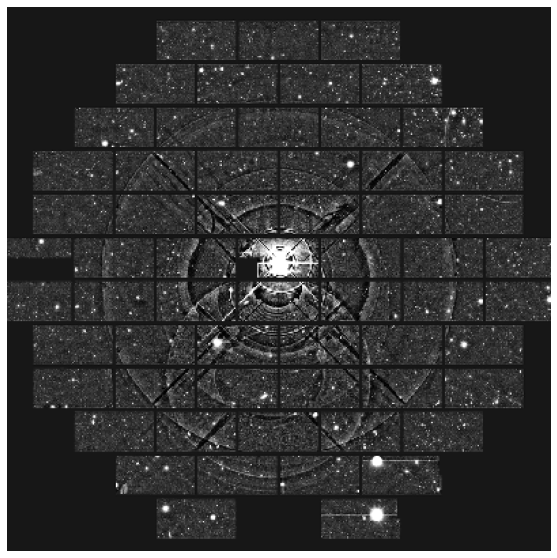

In [146]:
plt.figure(figsize=(10, 10))


plt.imshow(img,cmap='gray')
plt.imshow(mask_CCD,cmap='autumn',alpha=0.7)
plt.axis('off')

plt.savefig('Ray_572329.png')
plt.show()

Let's save this image

In [72]:
X_ghost_ex = np.zeros((400,400,3))

#Populate 
X_ghost_ex[:,:,0] = img
X_ghost_ex[:,:,1] = img
X_ghost_ex[:,:,2] = img
    
# Save the image
imageio.imwrite("Example_Ghost_img_{0}.jpg".format(expnum_loc),(X_ghost_ex*255.).astype(np.uint8))